# Entrega 5

In [72]:
import torch 
from torch.autograd import Variable
from sklearn.metrics import f1_score
#---
from glob import glob 
#---
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')


from PIL import Image

In [73]:
#!unzip mnist.zip

In [74]:
train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

In [75]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

  len(X_train), len(X_valid), len(X_test)

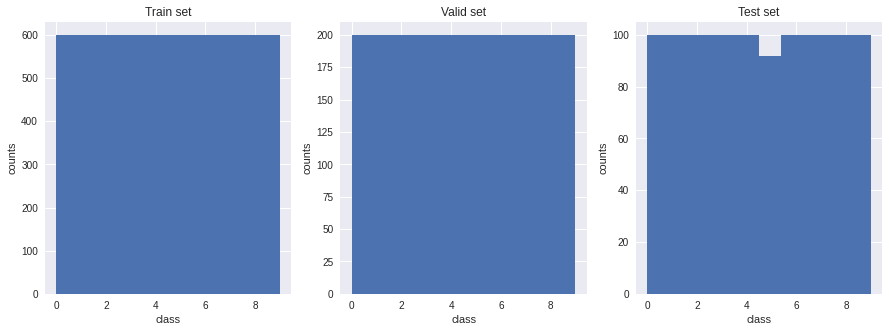

In [76]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

In [77]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [78]:
percentages = [0.1,0.2,0.5,0.8,1]
len(X_train)

6000

In [151]:
#--- Modelo
imput_dim = 28*28
out_dim = 10
hidden = 50
model = torch.nn.Sequential(
    torch.nn.Linear(imput_dim,hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden,out_dim)
)

optimizer =  torch.optim.Adam(model.parameters())
criterion =  torch.nn.CrossEntropyLoss()

def percentage_train_test(per,test_per=1):
  #per-> porcentaje de datos para entrenar 
  #test_per-> porcentaje de datos para testeo

  #Epocas
  n_epoch = 100
  #Entenamiento
  loss_train = []
  f1_train = []
  acc_train = []
  #Validación
  loss_valid = []
  f1_valid = []
  acc_valid = []
  # Datos parciales
  X_train_partial= X_train[0:int(len(X_train)*per)]
  Y_train_partial= Y_train[0:int(len(Y_train)*per)]

  X_test_partial= X_test[0:int(len(X_test)*test_per)]
  Y_test_partial= Y_test[0:int(len(Y_test)*test_per)]
  for epoch in range(n_epoch):


    model.train()
    
    Xtr = X_train_partial.view(X_train_partial.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_partial)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_partial,Y_pred, average='macro') )
    
    acc = sum(Y_train_partial == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)
  
  fig = plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(range(n_epoch), loss_train, label='train')
  plt.plot(range(n_epoch), loss_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('loss')
  plt.title('loss',fontsize=15)
  plt.legend()

  plt.subplot(1,3,2)
  plt.plot(range(n_epoch), f1_train, label='train')
  plt.plot(range(n_epoch), f1_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('f1_score')
  plt.title('f1_score',fontsize=15)
  plt.legend()

  plt.subplot(1,3,3)
  plt.plot(range(n_epoch), acc_train, label='train')
  plt.plot(range(n_epoch), acc_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('accuracy')
  plt.title('accuracy',fontsize=15)
  plt.legend()
  if test_per==1:
    fig.suptitle('Curvas para un porcentaje de datos de {}% '.format(per*100),fontsize=20)
  else:
    fig.suptitle('Curvas para un porcentaje de datos de {}% y un test de {}% de los datos '.format(per*100,test_per*100),fontsize=20)
  plt.show()
  model.eval()

  Xts = X_test_partial.view(X_test_partial.size(0), -1)
  Y_pred = model(Xts)  
  loss = criterion(Y_pred,Y_test_partial)

  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_test_partial, Y_pred, average='macro')

  acc = sum(Y_test_partial == Y_pred)/len(Y_pred)

  print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))
  print('------------------------------------------------------------------------------------------------------------------')
  return(loss.item(), f1, acc)

Curvas para un porcentaje de datos de 10.0% 


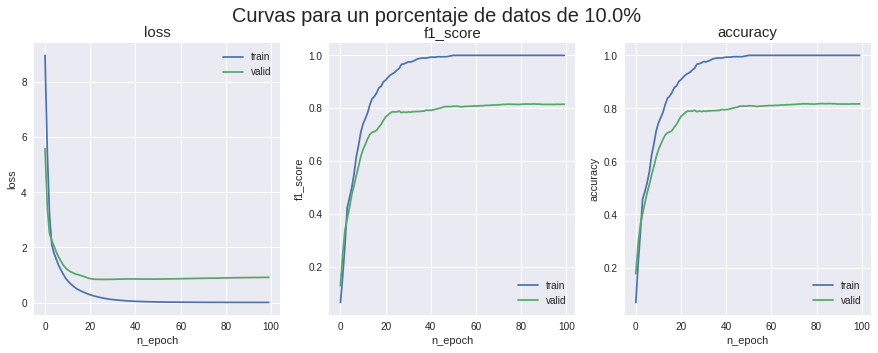

loss: 0.859131932258606, f1: 0.8180527546847965, acc: 0.819556474685669
------------------------------------------------------------------------------------------------------------------
Curvas para un porcentaje de datos de 20.0% 


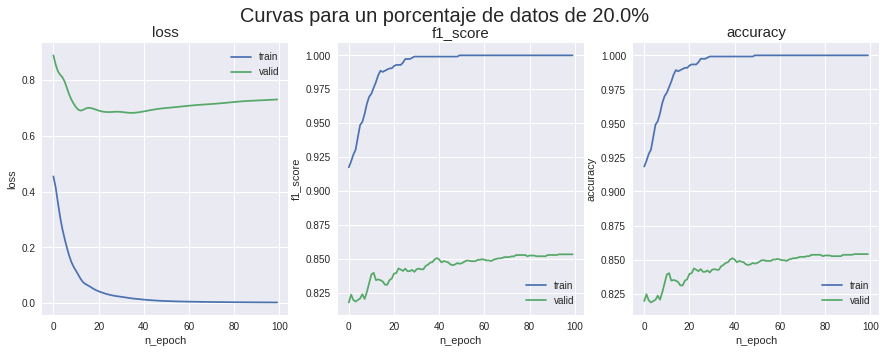

loss: 0.6882368326187134, f1: 0.8582544250432893, acc: 0.8588709831237793
------------------------------------------------------------------------------------------------------------------
Curvas para un porcentaje de datos de 50.0% 


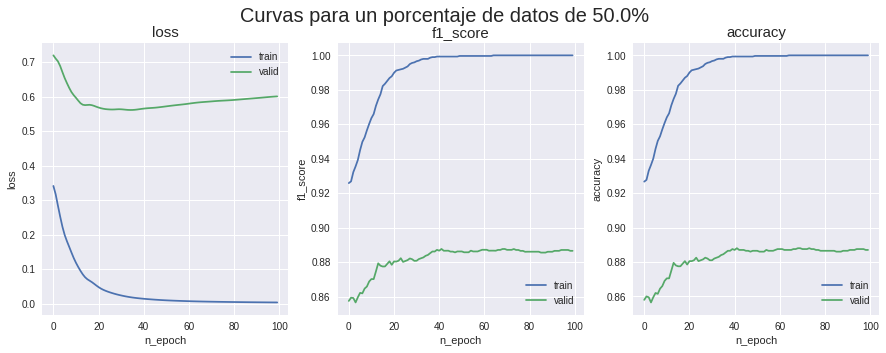

loss: 0.45311903953552246, f1: 0.9019043762401907, acc: 0.9022177457809448
------------------------------------------------------------------------------------------------------------------
Curvas para un porcentaje de datos de 80.0% 


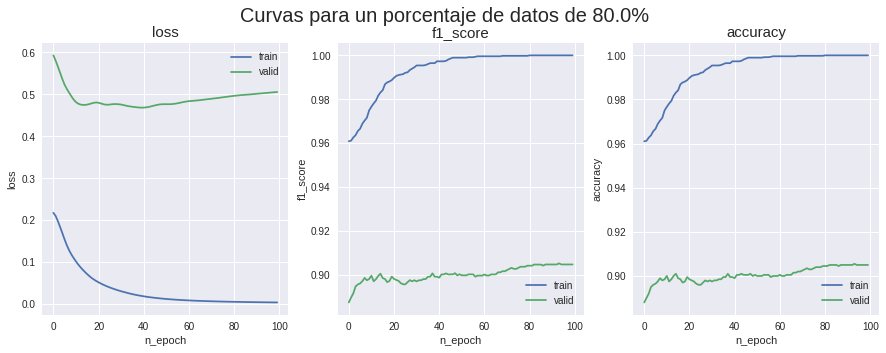

loss: 0.4204336702823639, f1: 0.9150531983555682, acc: 0.9153226017951965
------------------------------------------------------------------------------------------------------------------
Curvas para un porcentaje de datos de 100% 


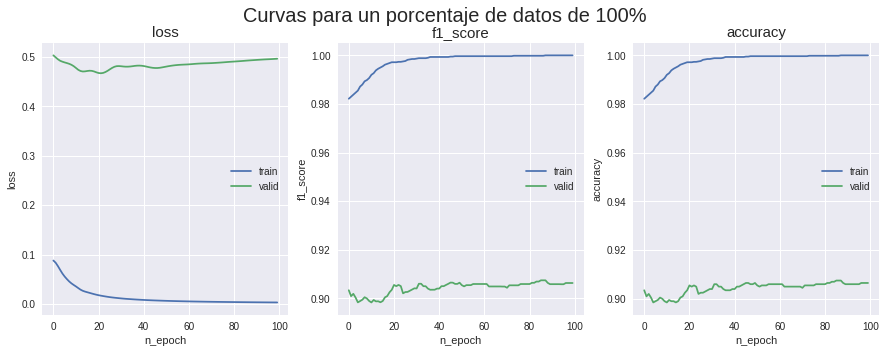

loss: 0.4827260971069336, f1: 0.9110854904880542, acc: 0.9112903475761414
------------------------------------------------------------------------------------------------------------------


In [152]:
loss_per = []
f1_per = []
accuracy_per =[]
for i in percentages:
  print( 'Curvas para un porcentaje de datos de {}% '.format(i*100) )
  a,b,c= percentage_train_test(i)
  loss_per.append(a)
  f1_per.append(b)
  accuracy_per.append(c)

<function matplotlib.pyplot.show>

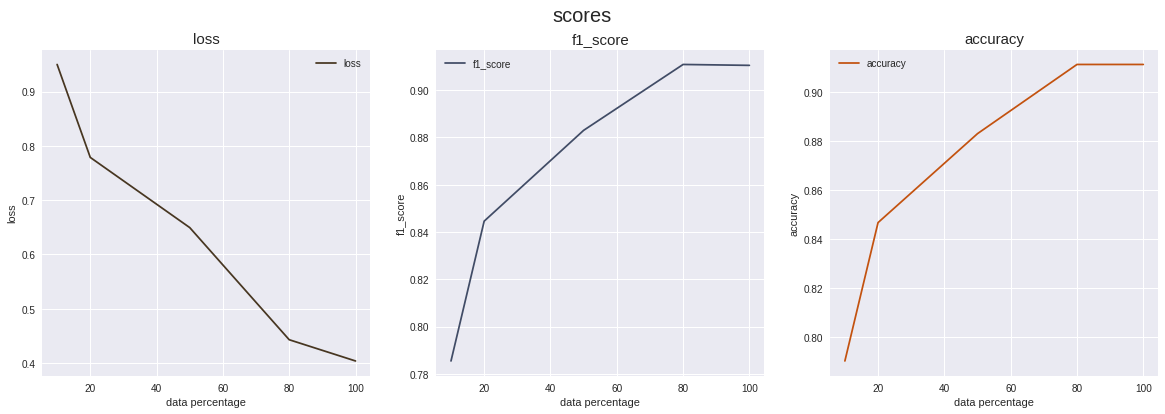

In [139]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(np.array(percentages)*100, loss_per, label='loss',color=np.random.rand(3,))
plt.ylabel('loss')
plt.xlabel('data percentage')
plt.title('loss',fontsize=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.array(percentages)*100, f1_per, label='f1_score',color= np.random.rand(3,))
plt.ylabel('f1_score')
plt.xlabel('data percentage')
plt.title('f1_score',fontsize=15)
plt.legend()


plt.subplot(1,3,3)
plt.plot(np.array(percentages)*100, accuracy_per, label='accuracy',color=np.random.rand(3,))
plt.ylabel('accuracy')
plt.xlabel('data percentage')
plt.title('accuracy',fontsize=15)
plt.legend()

fig.suptitle('scores % datos entrenamiento ',fontsize=20)
plt.show


Es posible observar  en las gráficas como a medida que se aumenta la cantidad de datos las perdidas (loss) tienden a disminuir, el score de modelo (f1_score) aumenta y la exactitud aumenta. Estas tres variables entonces indica como era de esperarse que con mayor número de datos mejor se entrena el modelo. 

Curvas para un porcentaje de datos de 10.0% 


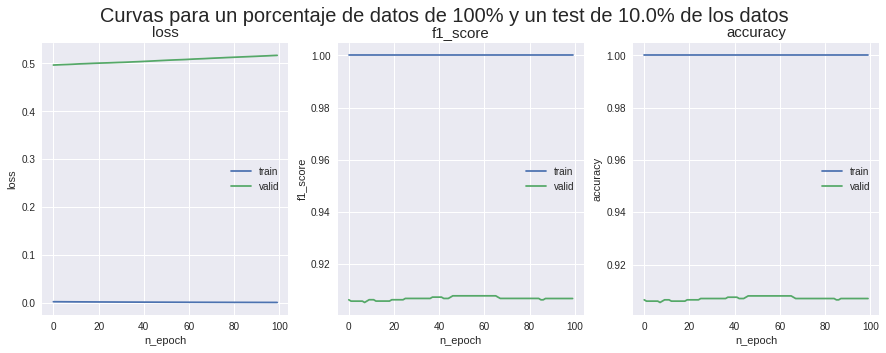

loss: 0.5872112512588501, f1: 0.9099337399557375, acc: 0.9090909361839294
------------------------------------------------------------------------------------------------------------------
Curvas para un porcentaje de datos de 20.0% 


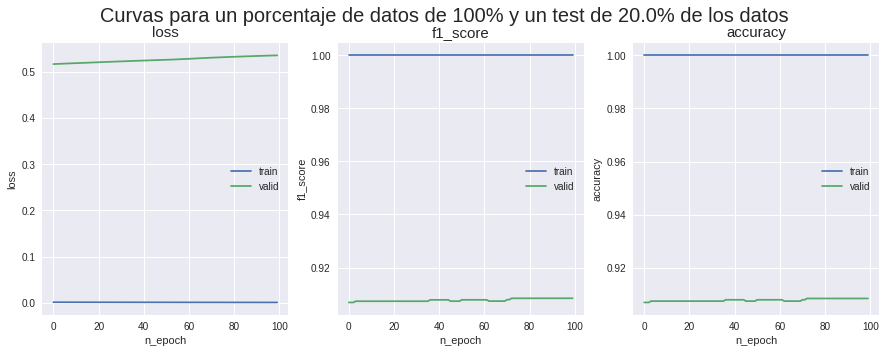

loss: 0.5124827027320862, f1: 0.9137869330406471, acc: 0.9141414165496826
------------------------------------------------------------------------------------------------------------------
Curvas para un porcentaje de datos de 50.0% 


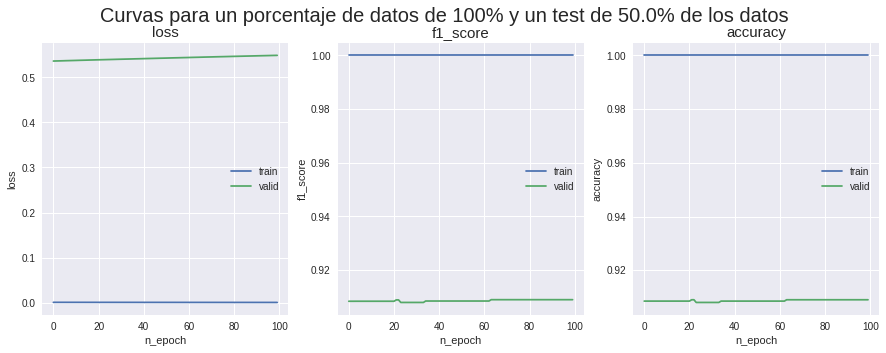

loss: 0.6444324254989624, f1: 0.9007088988881362, acc: 0.9012096524238586
------------------------------------------------------------------------------------------------------------------
Curvas para un porcentaje de datos de 80.0% 


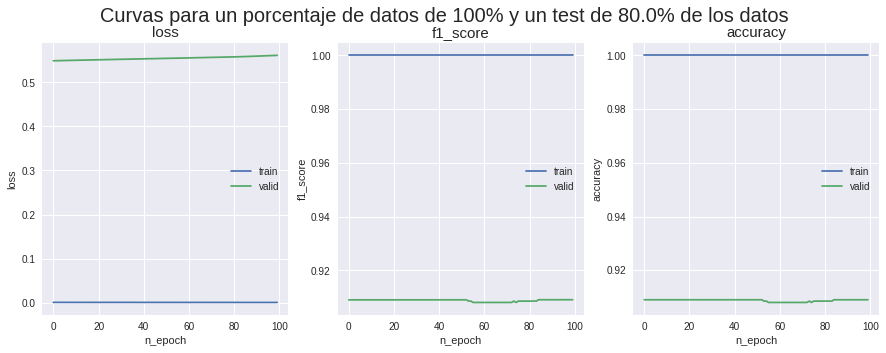

loss: 0.6137159466743469, f1: 0.9125321142654446, acc: 0.9129886627197266
------------------------------------------------------------------------------------------------------------------
Curvas para un porcentaje de datos de 100% 


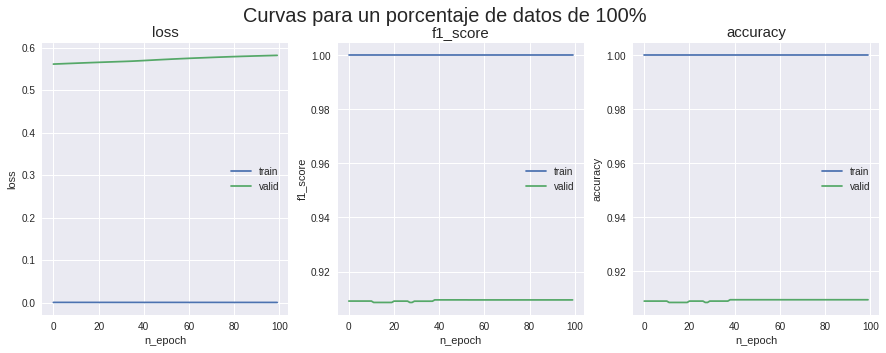

loss: 0.5853915214538574, f1: 0.9169585083188622, acc: 0.9173387289047241
------------------------------------------------------------------------------------------------------------------


In [154]:
loss_per_test = []
f1_per_test = []
accuracy_per_test =[]
for i in percentages:
  print( 'Curvas para un porcentaje de datos de {}% '.format(i*100) )
  a,b,c= percentage_train_test(1,i)
  loss_per_test.append(a)
  f1_per_test.append(b)
  accuracy_per_test.append(c)

<function matplotlib.pyplot.show>

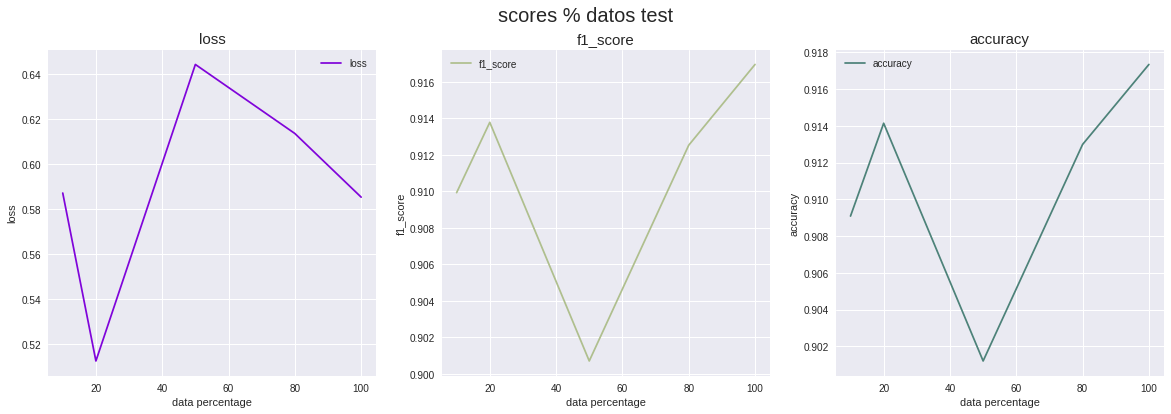

In [155]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(np.array(percentages)*100, loss_per_test, label='loss',color=np.random.rand(3,))
plt.ylabel('loss')
plt.xlabel('data percentage')
plt.title('loss',fontsize=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.array(percentages)*100, f1_per_test, label='f1_score',color= np.random.rand(3,))
plt.ylabel('f1_score')
plt.xlabel('data percentage')
plt.title('f1_score',fontsize=15)
plt.legend()


plt.subplot(1,3,3)
plt.plot(np.array(percentages)*100, accuracy_per_test, label='accuracy',color=np.random.rand(3,))
plt.ylabel('accuracy')
plt.xlabel('data percentage')
plt.title('accuracy',fontsize=15)
plt.legend()

fig.suptitle('scores % datos test ',fontsize=20)
plt.show



El cambio de los datos de testeo se observa que las curvas no tienen una tendencia definida y parecen no existir una correlación entre el número de datos del test y los resultados de score o  la evaluación del modelo aun que se perciben fluctuaciones en la variable y exite un tendencia  mejorar cuando se tiene más datos  no sería correcto afirmar que existen puntos más óptimos de testeo, ya que como se observa en la gráfica de abajo con ejes normalizadas (0,1) es posible que estas variaciones son muy pequeñas, no significativas por lo menos comparadas con el número de entrenamiento.


<function matplotlib.pyplot.show>

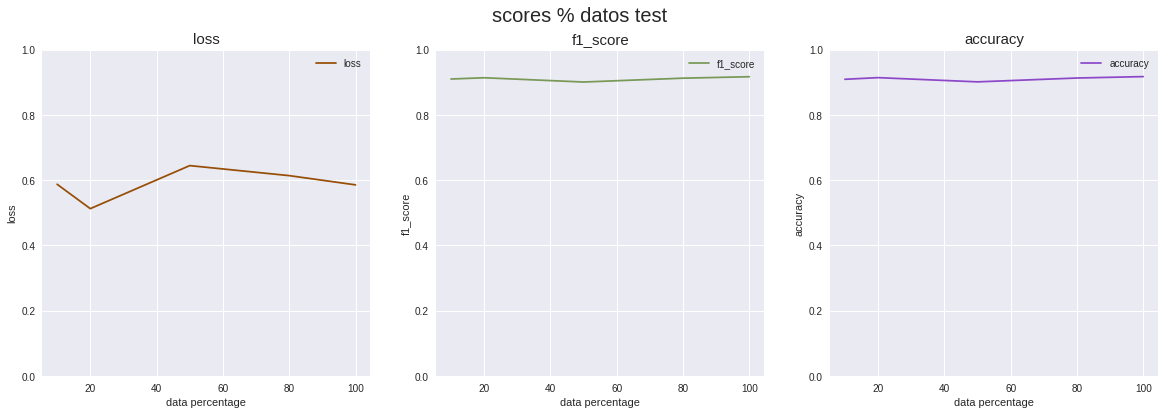

In [161]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(np.array(percentages)*100, loss_per_test, label='loss',color=np.random.rand(3,))
plt.ylabel('loss')
plt.xlabel('data percentage')
plt.title('loss',fontsize=15)
plt.ylim([0,1])
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.array(percentages)*100, f1_per_test, label='f1_score',color= np.random.rand(3,))
plt.ylabel('f1_score')
plt.xlabel('data percentage')
plt.title('f1_score',fontsize=15)
plt.ylim([0,1])
plt.legend()


plt.subplot(1,3,3)
plt.plot(np.array(percentages)*100, accuracy_per_test, label='accuracy',color=np.random.rand(3,))
plt.ylabel('accuracy')
plt.xlabel('data percentage')
plt.title('accuracy',fontsize=15)
plt.ylim([0,1])
plt.legend()

fig.suptitle('scores % datos test ',fontsize=20)
plt.show

<function matplotlib.pyplot.show>

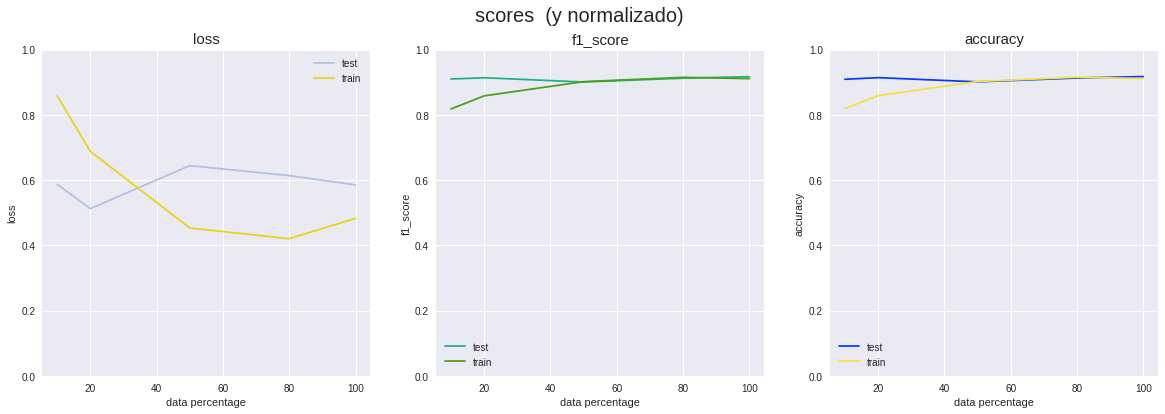

In [160]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(np.array(percentages)*100, loss_per_test, label='test',color=np.random.rand(3,))
plt.plot(np.array(percentages)*100, loss_per, label='train',color=np.random.rand(3,))
plt.ylabel('loss')
plt.xlabel('data percentage')
plt.title('loss',fontsize=15)
plt.ylim([0,1])
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.array(percentages)*100, f1_per_test, label='test',color= np.random.rand(3,))
plt.plot(np.array(percentages)*100, f1_per, label='train',color= np.random.rand(3,))
plt.ylabel('f1_score')
plt.xlabel('data percentage')
plt.title('f1_score',fontsize=15)
plt.ylim([0,1])
plt.legend()


plt.subplot(1,3,3)
plt.plot(np.array(percentages)*100, accuracy_per_test, label='test',color=np.random.rand(3,))
plt.plot(np.array(percentages)*100, accuracy_per, label='train',color=np.random.rand(3,))
plt.ylabel('accuracy')
plt.xlabel('data percentage')
plt.title('accuracy',fontsize=15)
plt.ylim([0,1])
plt.legend()

fig.suptitle('scores  (y normalizado) ',fontsize=20)
plt.show

Depúes 

* El codigo esta basado en el material de la clase, el cual se puede encontrar en:
https://github.com/ComputoCienciasUniandes/IntroDeepLearning_202102/blob/main/notebooks/09_Entrenamiento_Validaci%C3%B3n_Testeo.ipynb
